<h1 div class='alert alert-success'><center> Ponto de partida (EDA)</center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  OBJETIVO </div> 

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados dos datasets e estabelecer uma linha de base.

---

# <div class="alert alert-success">  1. IMPORTAÇÕES </div> 

## 1.1. Instalações

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2. Bibliotecas 

In [ ]:
import warnings
import random
import os
import gc
import torch

In [ ]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb

In [ ]:
from sklearn.model_selection import train_test_split,  KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder,normalize
from sklearn.impute          import SimpleImputer
from sklearn                 import metrics
from datetime                import datetime

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [ ]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    #warnings.filterwarnings(category=UserWarning)

    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    #warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 150)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    return icecream

icecream = jupyter_setting()

# Colors
dark_red = "#b20710"
black    = "#221f1f"
green    = "#009473"
myred    = '#CD5C5C'
myblue   = '#6495ED'
mygreen  = '#90EE90'

cols= [myred, myblue,mygreen]

In [ ]:
colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]

In [ ]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [ ]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [ ]:
def df_corr(df, annot_=False):
    
    df = df.corr(method ='pearson').round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    plt.figure(figsize=(15,12))
    ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");

In [ ]:
def describe(df):
    var = df.columns

    # Medidas de tendência central, média e mediana 
    ct1 = pd.DataFrame(df[var].apply(np.mean)).T
    ct2 = pd.DataFrame(df[var].apply(np.median)).T

    # Dispensão - str, min , max range skew, kurtosis
    d1 = pd.DataFrame(df[var].apply(np.std)).T
    d2 = pd.DataFrame(df[var].apply(min)).T
    d3 = pd.DataFrame(df[var].apply(max)).T
    d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

    # concatenete 
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
    
    return m

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [ ]:
def confusion_plot(matrix, labels = None, title = None):
        
    labels = labels if labels else ['Negative (0)', 'Positive (1)']    
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    sns.heatmap(data        = matrix, 
                cmap        = 'Blues', 
                annot       = True, 
                fmt         = 'd',
                xticklabels = labels, 
                yticklabels = labels, 
                ax          = ax);
    
    ax.set_xlabel('\n PREVISTO', fontsize=15)
    ax.set_ylabel('REAL \n', fontsize=15)
    ax.set_title(title)
    
    plt.close();
    
    return fig;

In [ ]:
def graf_outlier(df, feature):
    col = [(0,4), (5,9)]

    df_plot = ((df[feature] - df[feature].min())/
               (df[feature].max() - df[feature].min()))

    fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

    for i, (x) in enumerate(col): 
        sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

In [ ]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [ ]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
def graf_eval():

    results     = model.evals_result()
    ntree_limit = model.best_ntree_limit

    plt.figure(figsize=(20,7))

    for i, error in  enumerate(['mlogloss', 'merror']):#
        
        plt.subplot(1,2,i+1)
        plt.plot(results["validation_0"][error], label="Treinamento")
        plt.plot(results["validation_1"][error], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))
                    
        
        title_name ='\n' + error.upper() + ' PLOT \n'
        plt.title(title_name)
        plt.xlabel("Número de árvores")
        plt.ylabel(error)
        plt.legend();

## 1.4. Dataset

### 1.4.1. Descrição de dados

A área de estudo inclui quatro áreas selvagens localizadas na Floresta Nacional Roosevelt, no norte do Colorado. Cada observação é um patch de 30m x 30m. 

O conjunto de treinamento (train.csv) tem 4.000.000 observações e 55 variáveis, a variáveis que vamos prever é `Cover_Type` para o conjunto de teste (test.csv) que tem 1.000.000 observações.

Os sete tipos que contém a variável `Cover_Type` são:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

Variáveis do dataset:

- **Elevation**: Elevação em metros;
- **Aspect**: Aspecto em graus azimuth;
- **Slope**: Inclinação em graus;
- **Horizontal_Distance_To_Hydrology**: Horz Dist para variável de água de superfície mais próximos;
- **Vertical_Distance_To_Hydrology**: Vert Dist para recursos de água de superfície mais próximos;
- **Horizontal_Distance_To_Roadways**: Horz Dist para a estrada mais próxima;
- **Hillshade_9am**: índice Hillshade às 9h com valores entre 0 e 255;
- **Hillshade_Noon**: índice Hillshade ao meio-dia com valores entre 0 e 255;
- **Hillshade_3pm**: índice Hillshade às 3pm com valores entre 0 e 255;
- **Horizontal_Distance_To_Fire_Points**: Horz Dist para os pontos de ignição do incêndio florestal mais próximos;
- **Wilderness_Area**: (4 colunas binárias, 0 = ausência ou 1 = presença) - Designação de área selvagem;
- **Soil_Type**: (40 colunas binárias, 0 = ausência ou 1 = presença) - Designação do tipo de solo;
- **Cover_Type**: (7 tipos, inteiros 1 a 7) Designação do tipo de cobertura florestal.


In [ ]:
path   = '/content/drive/MyDrive/kaggle/Tabular Playground Series/2021/12 - Dezembro/'
target = 'Cover_Type'

In [ ]:
df1_train     = pd.read_csv(path + 'Data/train.csv')
df1_test      = pd.read_csv(path + 'Data/test.csv')
df_submission = pd.read_csv(path + 'Data/sample_submission.csv')

df1_train.drop('Id', axis=1, inplace=True)
df1_test.drop('Id', axis=1, inplace=True)

df1_train.shape, df1_test.shape, df_submission.shape

((4000000, 55), (1000000, 54), (1000000, 2))

In [ ]:
df1_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3189,40,8,30,13,3270,206,234,193,4873,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,3026,182,5,280,29,3270,233,240,106,5423,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
2,3106,13,7,351,37,2914,208,234,137,5269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,3022,276,13,192,16,3034,207,238,156,2866,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
4,2906,186,13,266,22,2916,231,231,154,2642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2


In [ ]:
df1_test.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2763,78,20,377,88,3104,218,213,195,1931,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2826,153,11,264,39,295,219,238,148,2557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2948,57,19,56,44,852,202,217,163,1803,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2926,119,6,158,134,2136,234,240,142,857,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2690,10,4,38,108,3589,213,221,229,431,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 1.3.1. Redução dos datasets

In [ ]:
df1_train = reduce_memory_usage(df1_train)
df1_test  = reduce_memory_usage(df1_test)

Mem. usage decreased to 244.14 Mb (85.5% reduction)
Mem. usage decreased to 60.08 Mb (85.4% reduction)


<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
Tivemos uma redução de 85% em ambos os datasets.
    
</div>

# <div class="alert alert-success"> 2. Análise Exploratória de Dados (EDA)  </div> 

## 2.1. Dimensão do DataSet

In [ ]:
print('TREINO')
print('Number of Rows: {}'.format(df1_train.shape[0]))
print('Number of Columns: {}'.format(df1_train.shape[1]), end='\n\n')

print('TESTE')
print('Number of Rows: {}'.format(df1_test.shape[0]))
print('Number of Columns: {}'.format(df1_test.shape[1]))

TREINO
Number of Rows: 4000000
Number of Columns: 55

TESTE
Number of Rows: 1000000
Number of Columns: 54


## 2.2. Tipo de dados

In [ ]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 55 columns):
 #   Column                              Dtype
---  ------                              -----
 0   Elevation                           int16
 1   Aspect                              int16
 2   Slope                               int8 
 3   Horizontal_Distance_To_Hydrology    int16
 4   Vertical_Distance_To_Hydrology      int16
 5   Horizontal_Distance_To_Roadways     int16
 6   Hillshade_9am                       int16
 7   Hillshade_Noon                      int16
 8   Hillshade_3pm                       int16
 9   Horizontal_Distance_To_Fire_Points  int16
 10  Wilderness_Area1                    int8 
 11  Wilderness_Area2                    int8 
 12  Wilderness_Area3                    int8 
 13  Wilderness_Area4                    int8 
 14  Soil_Type1                          int8 
 15  Soil_Type2                          int8 
 16  Soil_Type3                          

In [ ]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 55 columns):
 #   Column                              Dtype
---  ------                              -----
 0   Elevation                           int16
 1   Aspect                              int16
 2   Slope                               int8 
 3   Horizontal_Distance_To_Hydrology    int16
 4   Vertical_Distance_To_Hydrology      int16
 5   Horizontal_Distance_To_Roadways     int16
 6   Hillshade_9am                       int16
 7   Hillshade_Noon                      int16
 8   Hillshade_3pm                       int16
 9   Horizontal_Distance_To_Fire_Points  int16
 10  Wilderness_Area1                    int8 
 11  Wilderness_Area2                    int8 
 12  Wilderness_Area3                    int8 
 13  Wilderness_Area4                    int8 
 14  Soil_Type1                          int8 
 15  Soil_Type2                          int8 
 16  Soil_Type3                          

In [ ]:
print(f'{3*"="} For Pandas {10*"="}\n{(df1_train.dtypes).value_counts()}')
print(f'\n{3*"="} For Datatable {7*"="}\n{(df1_test.dtypes).value_counts()}')

=== For Pandas ==========
int8     46
int16     9
dtype: int64

=== For Datatable =======
int8     45
int16     9
dtype: int64


## 2.3. Identificar NA

In [ ]:
missing = missing_zero_values_table(df1_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 55 colunas e 4000000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [ ]:
missing = missing_zero_values_table(df1_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 54 colunas e 1000000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

Não temos dados faltantes.
    
</div>

## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [ ]:
feature_float = []
feature_cat   = df1_test.filter(regex=r'Wilderness_Area').columns.to_list() + \
                df1_test.filter(regex=r'Soil_Type').columns.to_list()

for col in df1_test.columns:
    if col not in feature_cat: 
        feature_float.append(col)   

feature_float_test = feature_float.copy()
feature_float.append('Cover_Type')

msg = 'Temos {} variávies numéricas e {} categóricas.'
print(msg.format(len(feature_float), len(feature_cat)))

Temos 11 variávies numéricas e 44 categóricas.


### 2.4.1 Atributos numéricos

- Train

In [ ]:
df1_train[feature_float].describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
Elevation,4000000.000000,2980.191660,289.048167,1773.000000,2760.000000,2966.000000,3217.000000,4383.000000
Aspect,4000000.000000,151.585671,109.961122,-33.000000,60.000000,123.000000,247.000000,407.000000
Slope,4000000.000000,15.097537,8.546731,-3.000000,9.000000,14.000000,20.000000,64.000000
Horizontal_Distance_To_Hydrology,4000000.000000,271.315436,226.549680,-92.000000,110.000000,213.000000,361.000000,1602.000000
Vertical_Distance_To_Hydrology,4000000.000000,51.662621,68.215966,-317.000000,4.000000,31.000000,78.000000,647.000000
Horizontal_Distance_To_Roadways,4000000.000000,1766.641630,1315.609890,-287.000000,822.000000,1436.000000,2365.000000,7666.000000
Hillshade_9am,4000000.000000,211.837542,30.759956,-4.000000,198.000000,218.000000,233.000000,301.000000
Hillshade_Noon,4000000.000000,221.061441,22.231335,49.000000,210.000000,224.000000,237.000000,279.000000
Hillshade_3pm,4000000.000000,140.810874,43.698639,-53.000000,115.000000,142.000000,169.000000,272.000000
Horizontal_Distance_To_Fire_Points,4000000.000000,1581.406810,1127.616169,-277.000000,781.000000,1361.000000,2084.000000,8075.000000


- Test

In [ ]:
df1_test[feature_float_test].describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
Elevation,1000000.000000,2969.602410,342.676046,1782.000000,2725.000000,2968.000000,3245.000000,4359.000000
Aspect,1000000.000000,152.231636,111.629725,-33.000000,59.000000,124.000000,251.000000,400.000000
Slope,1000000.000000,14.923460,8.457005,-3.000000,9.000000,14.000000,20.000000,63.000000
Horizontal_Distance_To_Hydrology,1000000.000000,264.368149,227.971753,-136.000000,102.000000,206.000000,356.000000,1583.000000
Vertical_Distance_To_Hydrology,1000000.000000,51.480362,68.520188,-329.000000,3.000000,31.000000,78.000000,634.000000
Horizontal_Distance_To_Roadways,1000000.000000,1713.507869,1374.922218,-264.000000,751.000000,1320.000000,2261.000000,7653.000000
Hillshade_9am,1000000.000000,211.659709,31.280435,1.000000,197.000000,218.000000,234.000000,296.000000
Hillshade_Noon,1000000.000000,221.476154,21.951950,53.000000,210.000000,224.000000,237.000000,276.000000
Hillshade_3pm,1000000.000000,139.861454,45.398002,-51.000000,114.000000,142.000000,169.000000,270.000000
Horizontal_Distance_To_Fire_Points,1000000.000000,1665.384311,1212.225118,-267.000000,820.000000,1416.000000,2149.000000,8007.000000


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

O que me chamou atenção é valor negativo para a maioria das variáveis exceto para `Hillshade_Noon` em ambos os dataset e para a variável `Hillshade_9am` apenas no dataset de test, pode ser um indicativo de algum problema na coleta de informações, mas com se trata de informações de `Cobertura Florestal` pode fazer sentido. É um ponto que temos que levar em consideração no processamento de dados.  
    
</div>

### 2.4.2. Atributos categóricos

In [ ]:
df1_train[feature_cat].columns

Index(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

In [ ]:
df1_train.filter(regex=r'Wil').head()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Temos quatros variáveis que podemos transformar em dammy, isso pode ajudar a melhor a performance dos modelos. 

    
</div> 

## 2.5. Correlação
Vamos examinar a correlação entre as variáveis.

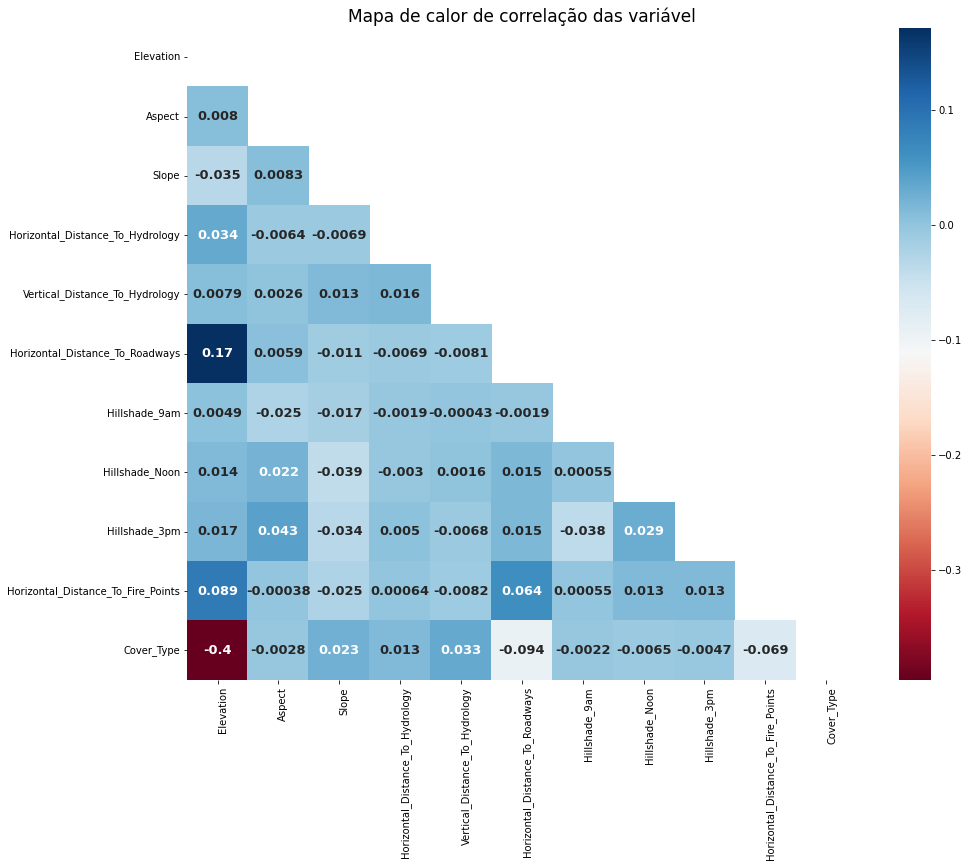

In [ ]:
df_corr(df1_train[feature_float], annot_=True)

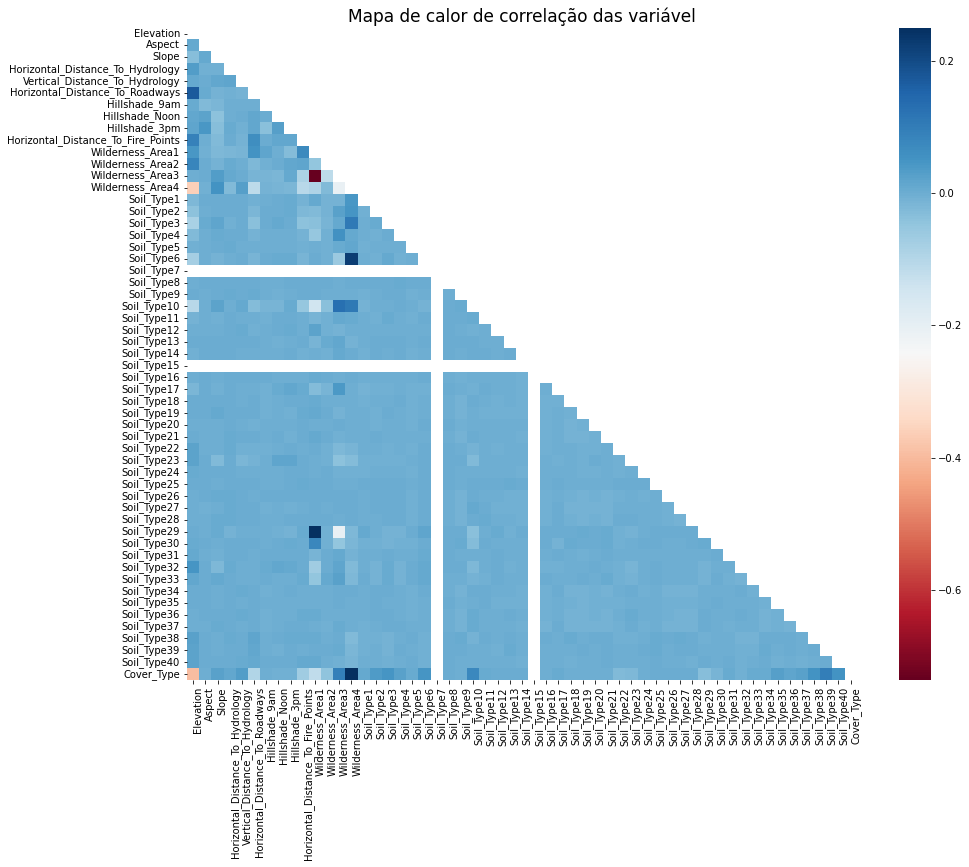

In [ ]:
df_corr(df1_train)

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Como podemos observar, a correlação está entre -0.6 e 0.2, o que é muito pequeno, portanto, as variáveis são fracamente correlacionados.
    
</div>

## 2.6. Distribuição

### 2.6.1. Train / Test

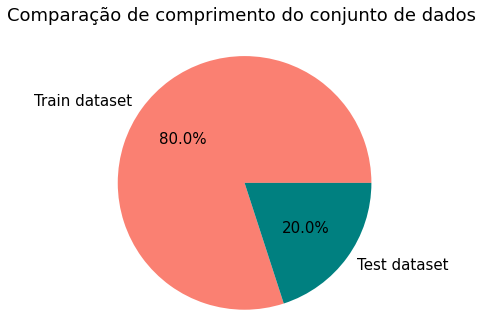

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df1_train), len(df1_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

### 2.6.2. Proporção de variáveis

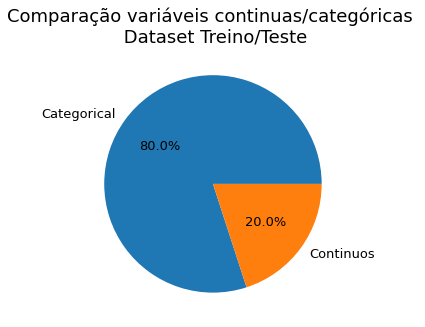

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.pie([ len(feature_cat), len(feature_float)], 
        labels=['Categorical', 'Continuos' ],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')

#ax.axis("equal")
ax.set_title("Comparação variáveis continuas/categóricas \n Dataset Treino/Teste", fontsize=18)
fig.set_facecolor('white')
plt.show()

### 2.6.3. Variável predidora

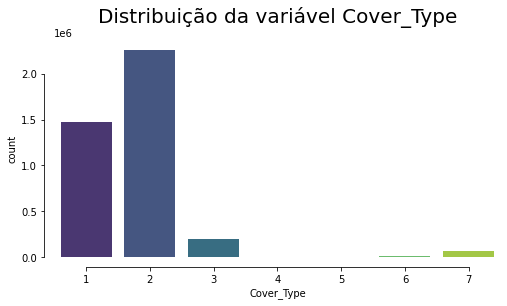

In [ ]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=df1_train['Cover_Type'], palette='viridis')
ax.set_title('Distribuição da variável Cover_Type', fontsize=20, y=1.05)

sns.despine(right=True)
sns.despine(offset=10, trim=True)

In [ ]:
stat = pd.DataFrame(df1_train['Cover_Type'].value_counts())
stat['percent_type'] = stat['Cover_Type'] / stat['Cover_Type'].sum()

stat.style.bar(subset=["percent_type"], color='orange').format('{:.2%}', subset=["percent_type"])

,Cover_Type,percent_type
2,2262087,56.55%
1,1468136,36.70%
3,195712,4.89%
7,62261,1.56%
6,11426,0.29%
4,377,0.01%
5,1,0.00%


<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
Observamos no gráfico acima que a classe 2 é a mais representativa, seguida pela classe 1. As classes raras são 4, 5 e 6, a classe 5 com apenas um único exemplo podemos fazer a exclusão ou associá-la a outra classe, mas para isso devemos analisar a associação dessa classe, pois terá um impacto mínimo na classificação.     

    
</div>

### 2.6.4. Distribuição Train x Test

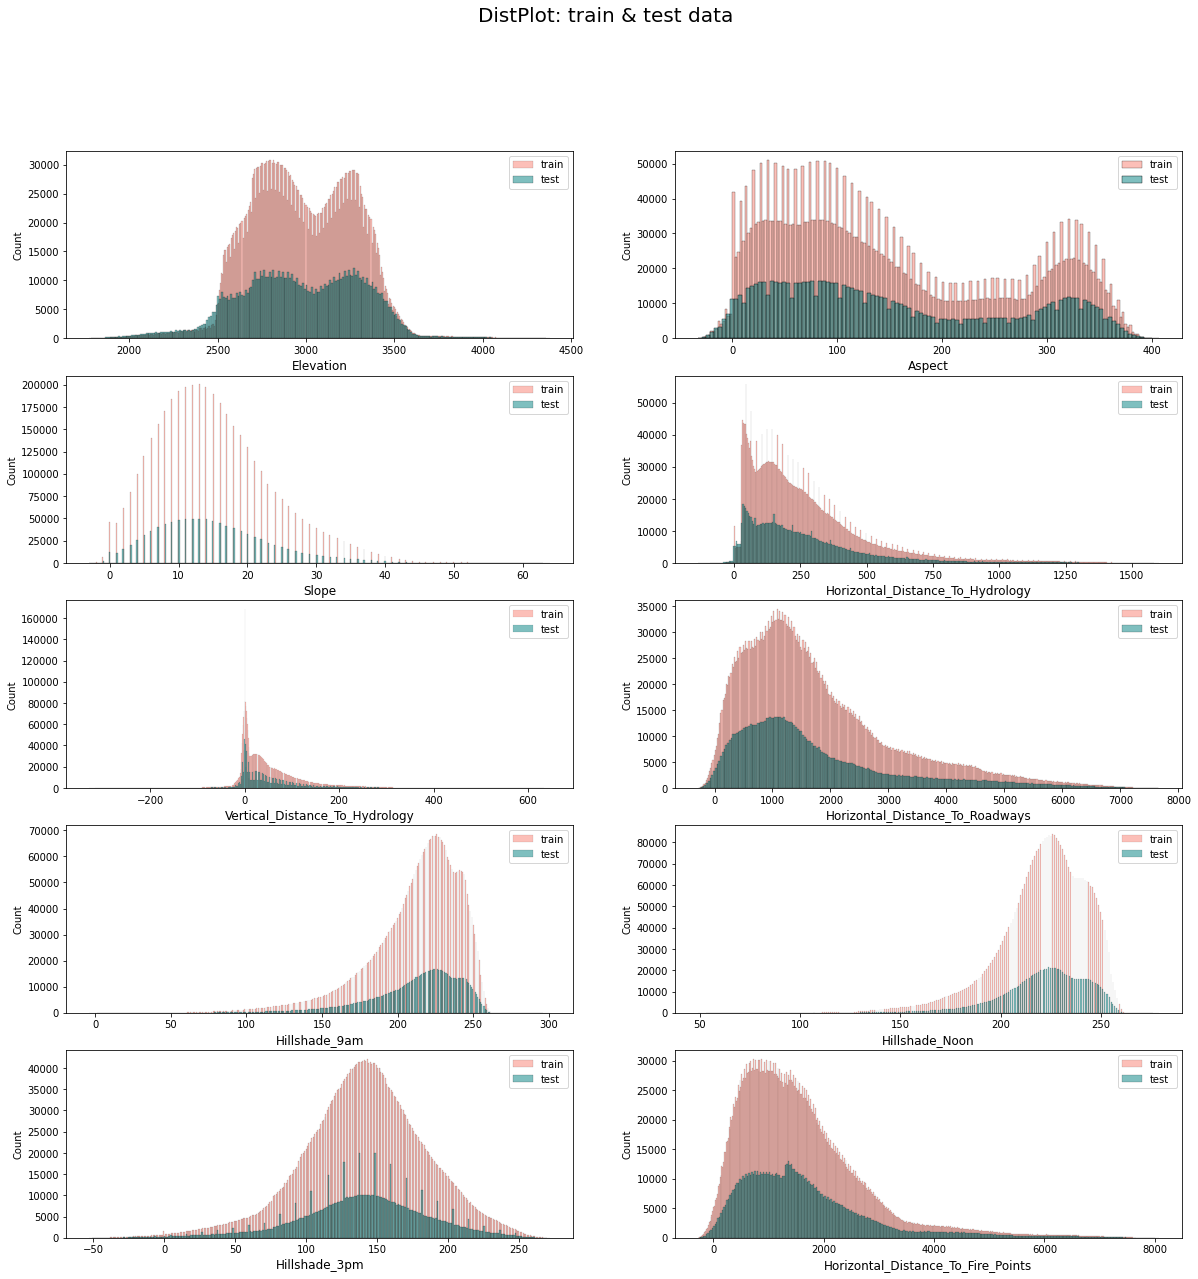

In [ ]:
fig, ax = plt.subplots(5,2 ,figsize=(20,20))
for i,feature in enumerate(feature_float_test):
    plt.subplot(5,2,i+1)
    sns.histplot(data=df1_train,x=df1_train[feature],color='salmon', alpha=0.5, label='train')
    sns.histplot(data=df1_test ,x=df1_test[feature],color='teal', alpha=0.5, label='test')     
    plt.xlabel(feature, fontsize=12)
    plt.legend()
         
plt.suptitle('DistPlot: train & test data', fontsize=20);

### 2.6.5.  Variáveis categoricas

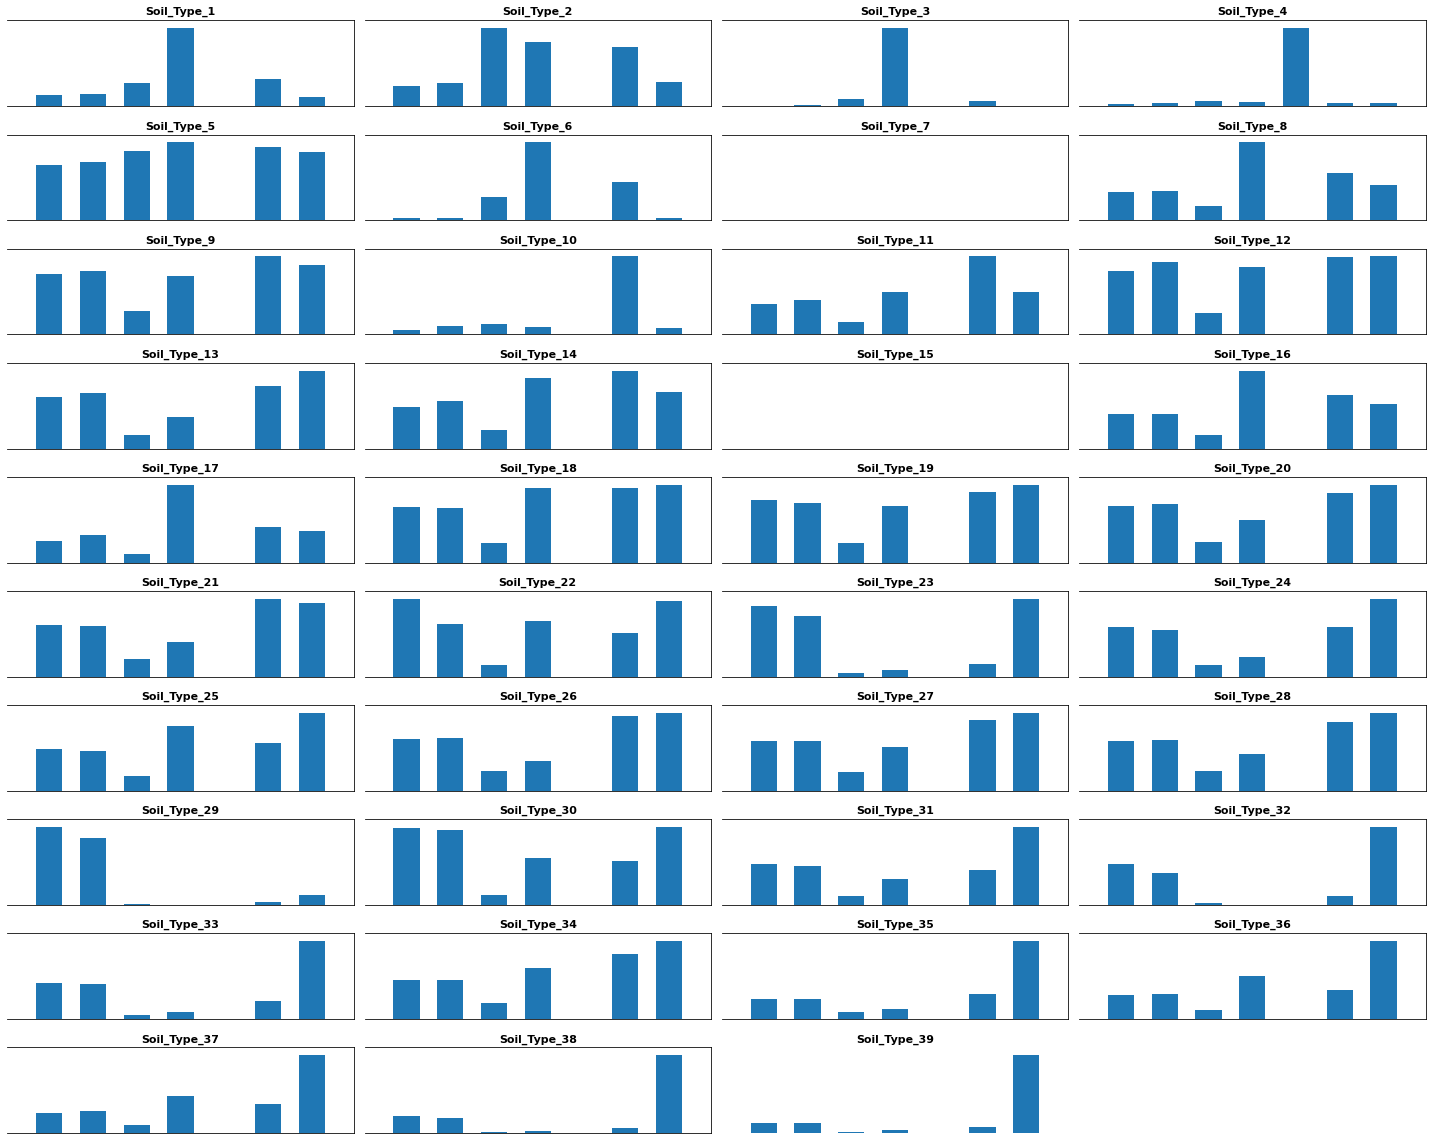

In [ ]:
fig, axes = plt.subplots(10, 4, figsize=(20, 16))

target_order = sorted(df1_train['Cover_Type'].unique())
mean         = df1_train.groupby('Cover_Type').mean().sort_index()
std          = df1_train.groupby('Cover_Type').std().sort_index()

for idx, ax in zip(range(1,40), axes.flatten()):
    
    ax.bar(mean[f'Soil_Type{idx}'].index, 
           mean[f'Soil_Type{idx}'],           
           width=0.6)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.margins(0.1)
    
    ax.spines['left'].set_visible(False)
    ax.set_title(f'Soil_Type_{idx}', loc='center', weight='bold', fontsize=11)

axes.flatten()[-1].axis('off')    
axes.flatten()[-2].axis('off')

#fig.supxlabel('Média por classe (por variável)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
Variáveis `Soil_Type_7` e `Soil_Type_15` não tem informações, neste caso podemos excluí-las.    
    
</div>

## 2.6.6. Detecção de Outlier

In [ ]:
def graf_outlier(df, feature_, target_):
    
    fig_out, axes_out=plt.subplots(3, 4, figsize=(20,15))
    j=0
    i=0
    
    for col in feature_:
        if j==4:
            i+=1
            j=0

        sns.boxplot(y    = col,
                    x    = target_,
                    data = df,
                    ax   = axes_out[i,j])

        plt.gca().set_title(f"{col}")

        j+=1

### 2.6.6.1. Data Train 

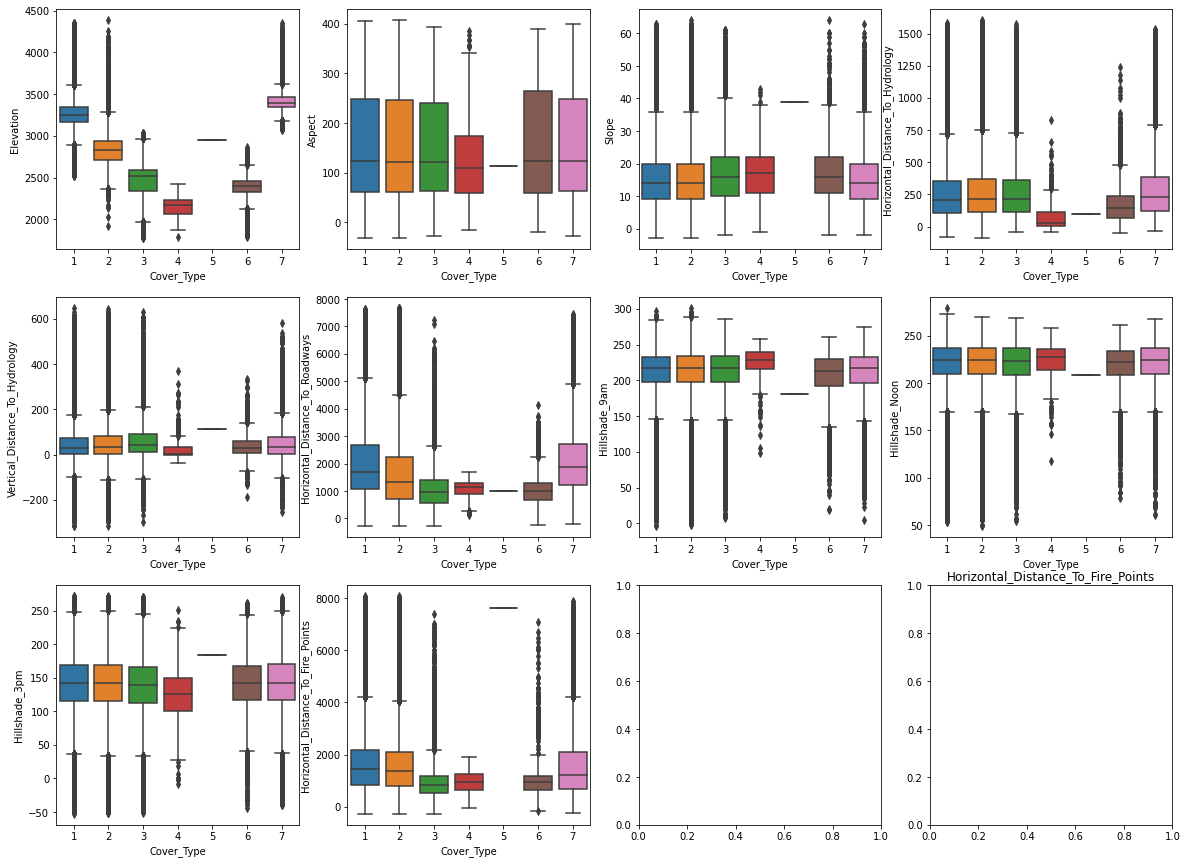

In [ ]:
graf_outlier(df1_train,feature_float_test, target)

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Acima observamos que temos que fazer um tratamento de outliers em algumas variáveis, na etapa de processamento vamos fazer o tramento ou remoção dos outliers para ajudar na previsão dos modelos. 

</div>

# <div class="alert alert-success"> 3. Modelagem (baseline) </div> 

## 3.1. Split Train/Test

In [ ]:
df1_train[target].value_counts()

2    2262087
1    1468136
3     195712
7      62261
6      11426
4        377
5          1
Name: Cover_Type, dtype: int64

In [ ]:
df1_train.drop(df1_train[df1_train[target]==5].index, inplace=True)

In [ ]:
%%time

X      = df1_train.drop([target], axis=1)
y      = df1_train[target].astype(int)
X_test = df1_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.3,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

#del df1_train,df1_test

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

CPU times: user 3.02 s, sys: 113 ms, total: 3.13 s
Wall time: 3.11 s


## 3.2. Parametros do modelo

In [ ]:
seed   = 12359
params = {"objective"     : 'multi:softmax',    
          'eval_metric'   : 'mlogloss',         
          'random_state'  : seed, 
          'n_jobs'        : -1}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'
                   })
params

{'objective': 'multi:softmax',
 'eval_metric': 'mlogloss',
 'random_state': 12359,
 'n_jobs': -1,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

## 3.2. Seleção de Scaler

In [ ]:
%%time 

model_baseline = xgb.XGBClassifier(**params)

scalers = [None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
           ]

for scaler in scalers: 
    
    if scaler!=None:
        X_train_s = scaler.fit_transform(X_train)
        X_valid_s = scaler.fit_transform(X_valid)
    else:
        X_train_s = X_train
        X_valid_s = X_valid
                
    model_baseline.fit(X_train_s, y_train, verbose=False)

    y_pred = model_baseline.predict(X_valid_s)  
    acc    = metrics.accuracy_score(y_valid, y_pred)    
        
    print('Validaçao ACC: {:2.5f} => {}'.format(acc, scaler))

    free_gpu_cache()

print()

Validaçao ACC: 0.92854 => StandardScaler()

CPU times: user 38.1 s, sys: 219 ms, total: 38.3 s
Wall time: 38.1 s


<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Com scaler  RobustScaler obtivemos uma ACC de 0.92970, como estamos fazer apenas uma validação simples, neste caso a pontuação do score pode ser afetada por aleatoriedade dos dados, sendo assim, vamos fazer uma validação cruzada para termos uma estimativa robusta.  <br>
    
</div>

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, fold_=5, path_='', 
                    seed_=12359, feature_scaler_=None, print_report_=False):
    
    n_estimators = model_.get_params()['n_estimators']
         
    
    valid_preds  = {}
    taco         = 76 
    acc_best     = 0
    col_prob     = y_.unique()    
    df_proba     = pd.DataFrame()
    test_preds   = []
    test_pred_proba = np.zeros((1, 1))

    for scaler_ in scalers_: 

        time_start   = datetime.now()
        score        = []
        
                
        if scaler_!=None:
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
            if feature_scaler_!=None:
                X_tst = X_test_.copy()
                X_tst[feature_scaler_] = scaler_.fit_transform(X_tst[feature_scaler_].copy())
            else: 
                X_tst = scaler_.fit_transform(X_test_.copy())
        else:
            string_scaler = None 
            X_tst = X_test_.copy()
            
        y_pred_test = np.zeros(len(X_test_))

        folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        #folds = StratifiedShuffleSplit(n_splits=fold_, test_size=0.5, random_state=seed_)
                
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)

        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

            time_fold_start = datetime.now()

            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                if feature_scaler_!=None: 
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.fit_transform(X_val[feature_scaler_])  
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.fit_transform(X_val)
            
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val      = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_test    += model_.predict(X_tst) / folds.n_splits

            test_preds.append(model_.predict(X_tst))
            
            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx
            df_prob_temp['y_val']   = y_val.values
            df_prob_temp['y_pred']  = y_pred_val            
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
            df_prob_temp['scaler']  = str(string_scaler)
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            f1    = metrics.f1_score(y_val, y_pred_val, average='weighted')
            prec  = metrics.precision_score(y_val, y_pred_val, average='macro')
            
            score.append(acc)            

            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] ACC: {:2.5f} - F1-macro: {:2.5f} - Precision: {:2.5f}  - {}'
            print(msg.format(fold+1, acc, f1, prec, time_fold_end))

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)

        if acc_mean > acc_best:     
            acc_best    = acc_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        print('-'*taco)
        print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))
        print('='*taco)
        print()

        df_submission[target_] = y_pred_test.astype('int')
        name_file_sub = 'Data/submission/' + model_name_ + '_' + str(scaler_).lower()[:4] + '.csv'
        df_submission.to_csv(path_ + name_file_sub.format(acc_mean), index = False)

        if print_report_:
            y_pred = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_val']
            print(metrics.classification_report(y_vl,y_pred))

    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()

    return model_ , df_prob_temp.sort_values(by=['scaler','id'])

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy =  {1: 1468136, 
                      2: 2262087, 
                      3: 195712, 
                      4: 377    + 10000, 
                      6: 11426  + 7000, 
                      7: 62261  + 10000
                      
                      }

oversample = RandomOverSampler(sampling_strategy=sampling_strategy,  random_state=12359)

X_over, y_over = oversample.fit_resample(X, y)

# 1	1468136	0,38565
# 2	2262087	0,51259
# 3	 195712	0,07817

y_over.value_counts()

2    2262087
1    1468136
3     195712
7      72261
6      18426
4      10377
Name: Cover_Type, dtype: int64

In [ ]:
%%time 
scalers = [None,
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
          ] 

seed     = 12359
y_unique = y.unique()

sample_weights = compute_sample_weight(class_weight='balanced', y=y)
                 
eval_metric = ['mlogloss','merror']
        
params = {"objective"        : 'multi:softmax', # multi:softprob', #,    
          'eval_metric'      : eval_metric, 
          'learning_rate'    : 0.4,  
          'sample_weight'    : sample_weights, 
          'num_class'        : len(y.unique()),
          'random_state'     : seed, 
          'n_jobs'           : -1}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba = cross_val_model(model_         = xgb.XGBClassifier(**params),
                                  model_name_    = 'xgb_baseline_score_{:2.5f}',
                                  X_             = X,
                                  y_             = y,
                                  X_test_        = X_test,
                                  target_        = target,
                                  scalers_       = scalers,
                                  fold_          = 5, 
                                  path_          = path,
                                  seed_          = seed, 
                                  feature_scaler_= feature_float_test, 
                                  print_report_  = True
                                  )

#graf_eval()
print()

Scaler: None - n_estimators: 100
[Fold 1] ACC: 0.95068 - F1-macro: 0.94955 - Precision: 0.79367  - 0h 0m 51s
[Fold 2] ACC: 0.95085 - F1-macro: 0.94970 - Precision: 0.83290  - 0h 0m 51s
[Fold 3] ACC: 0.95039 - F1-macro: 0.94914 - Precision: 0.77931  - 0h 0m 51s
[Fold 4] ACC: 0.95076 - F1-macro: 0.94958 - Precision: 0.77377  - 0h 0m 51s
[Fold 5] ACC: 0.95101 - F1-macro: 0.94990 - Precision: 0.79678  - 0h 0m 51s
----------------------------------------------------------------------------
[Mean Fold] ACC: 0.95074 std: 0.00021 - 0h 4m 18s

              precision    recall  f1-score   support

           1       0.94      0.96      0.95    293627
           2       0.96      0.97      0.97    452417
           3       0.90      0.82      0.86     39143
           4       0.50      0.36      0.42        75
           6       0.66      0.38      0.48      2285
           7       0.82      0.59      0.68     12452

    accuracy                           0.95    799999
   macro avg       0.80  

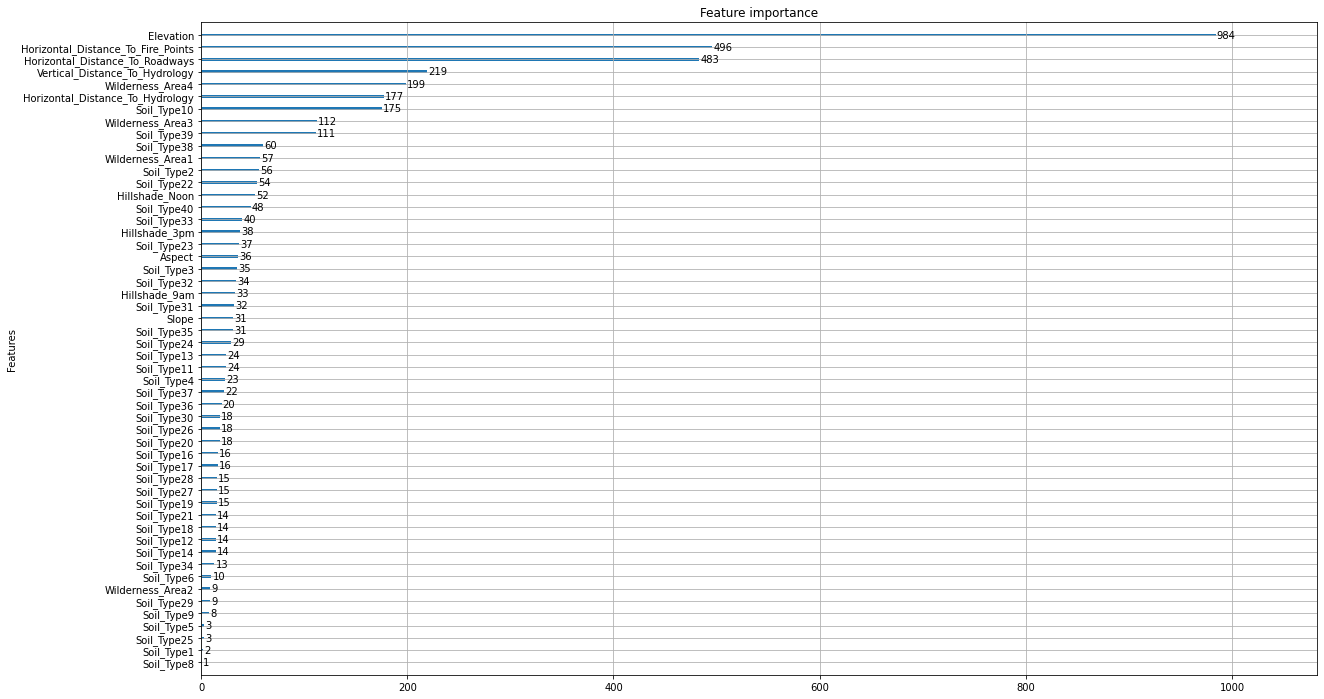

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(20,12))
plot_importance(model,ax=ax, xlabel=None)
plt.show()

<div class="alert alert-info" role="alert"> 
 
**`CONCLUSÃO:`** <br>
    
1. Verificar os valores negativos identificados na análise descritiva dos dados; 
2. Transformação das variáveis `Wilderness_Area` em dammy;
3. Tratamento de outliers; 
4. Exclusão das variáveis `Soil_Type_7` e `Soil_Type_15` sem informações para modelagem. 
    
    
</div>